In [1]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.externals import joblib

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix, roc_auc_score,roc_curve,auc

from sklearn.pipeline import Pipeline

In [4]:
ls

1.LR-TFIDF.pkl                        Pipeline.py
1.LR.pkl.                             Plot.py
2.GB-TFIDF.pkl                        Train.py
2.GB.pkl                              XmlToJson.py
3.GB-TFIDF.pkl                        __pycache__/
3.GB.pkl                              demo.xml
Helper.py                             smokers_surrogate_all_data copy.json
Pipeline copy.py


# EDA

**Check Layer 1 notebook for first layer of classification **


In [5]:
#converted xml to json
df0 = pd.read_json('smokers_surrogate_all_data copy.json')

In [6]:
df=df0.copy()

In [7]:
#Transposing to rearrange columns
df=df.T

In [8]:
df=df.reset_index()

In [9]:
#giving columns names
df.columns = ['id', 'smoking_status','descrp']

In [10]:
sw=['summaryunsigneddisreport','yregistration','amed','date','patient','mm', 'st','amdischarge','doctor', 'hospital',
    'surgery','pain','problem','discharge','admission','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
    'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am','be',
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'of', 'at', 'by', 'for', 'about', 'against', 
    'between', 'into', 'through', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'further', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'more', 
    'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'just', 'don', "don't",
    'should', "should've", 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'ma', 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'won', "won't", 'wouldn', "wouldn't"
    'aboard','about','above','across','along','an','and','another','any','around','as','at','below','behind','below'
    ,'beneath','beside','beyond','certain','down','during','each','following','for','from','inside','into','its',
    'like','minus','my','near','next','opposite','outside','out','over','plus','round','so','some','than','through',
    'toward','underneath','unlike','yet','under','unsigneded']


In [10]:
def text_process(description):
    
    
        
    nopunc=[char for char in description if char not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    splitnum  = re.split('(\d+)',nopunc)
    splitnum=' '.join(splitnum)
    new=re.sub(" \d+", " ", splitnum)
 
    
    
    swtext= [word.lower() for word in new.split() if word not in [x.upper() for x in sw]]
    
    return ' '.join(swtext)


# Classification -Level 1

In [11]:
# seperating records based on unknown and known smoking related text status
def unknown(column):
    if 'UNKNOWN' in column :
        return 1

    else: return 0

df["smoking_unknown"] = df["smoking_status"].apply(unknown)

In [12]:
df.head()

,id,smoking_status,descrp,smoking_unknown
0,667,UNKNOWN,763970014CMC8590556704/21/1994 12:00:00 AMDisc...,1
1,666,UNKNOWN,220536305CMC8286358010/8/1994 12:00:00 AMDisch...,1
2,665,UNKNOWN,082738817CMC191536296/3/1993 12:00:00 AMDischa...,1
3,663,NON-SMOKER,498710998CMC1417244504/29/1992 12:00:00 AMDisc...,0
4,662,UNKNOWN,244815666HLGMC444992302133/2wwh3/3/1994 12:00:...,1


In [13]:
df.smoking_unknown.value_counts()

1    315
0    187
Name: smoking_unknown, dtype: int64

# Classification- Level 2

In [14]:
df1=df.copy()

In [15]:
#Only seperating those row which have some information about smoking

secondf=df1[df1.smoking_unknown==0]

In [16]:
secondf.head()

,id,smoking_status,descrp,smoking_unknown
3,663,NON-SMOKER,498710998CMC1417244504/29/1992 12:00:00 AMDisc...,0
6,660,PAST SMOKER,156406283HLGMC721364564723/51cy5/28/1993 12:00...,0
7,571,NON-SMOKER,851842962FIH618594423763/49880527109/14/1993 1...,0
9,691,NON-SMOKER,763428002BH351599790954408/07/2002 12:00:00 AM...,0
10,696,NON-SMOKER,139964603NVH4087653111/17/2003 12:00:00 AMPELV...,0


## Data preprocessing

In [17]:
# Out of the known smoking records, classifiy them based on the non smoker status
def smokerclass(column):
    if 'NON-SMOKER' in column :
        return 1

    else: return 0

secondf["smoking_nonsmoker"] = secondf["smoking_status"].apply(smokerclass)

/Users/Faliha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
secondf.head()

,id,smoking_status,descrp,smoking_unknown,smoking_nonsmoker
3,663,NON-SMOKER,498710998CMC1417244504/29/1992 12:00:00 AMDisc...,0,1
6,660,PAST SMOKER,156406283HLGMC721364564723/51cy5/28/1993 12:00...,0,0
7,571,NON-SMOKER,851842962FIH618594423763/49880527109/14/1993 1...,0,1
9,691,NON-SMOKER,763428002BH351599790954408/07/2002 12:00:00 AM...,0,1
10,696,NON-SMOKER,139964603NVH4087653111/17/2003 12:00:00 AMPELV...,0,1


In [19]:
secondf.smoking_nonsmoker.value_counts()

0    105
1     82
Name: smoking_nonsmoker, dtype: int64

### Modeling

In [20]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_label):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    prob=classifier.predict_proba(feature_vector_test)
    pred=prob[:,1]
    print ("{} ".format(classifier))
    print ('Accuracy:',accuracy_score(predictions, test_label))
    print ('Recall:',recall_score(predictions, test_label),)
    print ('Precision:',precision_score(predictions, test_label))
    print ('F1:',f1_score(predictions, test_label))
    print ('ROC:',roc_auc_score(test_label,pred))
    print ('CM:',confusion_matrix(predictions, test_label))
    return accuracy_score(predictions, test_label), recall_score(predictions, test_label),precision_score(predictions, test_label), f1_score(predictions, test_label),roc_auc_score(test_label,pred), confusion_matrix(predictions, test_label),pred


In [21]:
def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    

    print(cm)

    # Show confusion matrix in a separate window
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d',xticklabels=['Known','Unknown'],yticklabels=['Known','Unknown'])
    plt.title('Confusion matrix')
    
    
    
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
X  = secondf['descrp']
y = secondf['smoking_nonsmoker']


In [23]:
X_train,  X_test,  y_train, y_test  =  train_test_split(X,y,test_size=0.25, random_state=50)

#### Random Forest

In [24]:

tfidf_vect = TfidfVectorizer(use_idf= True,norm= 'l1',preprocessor=text_process,ngram_range= (1, 3),
                             min_df= 2,max_df=0.9)


tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)


In [25]:
len(tfidf_vect.vocabulary_)



23580

In [26]:
accuracy_rf, recall_rf, precision_rf, f1_rf,roc_rf, cm_rf,pred_rf = train_model(RandomForestClassifier
                                            (n_estimators= 80,min_samples_split=7,min_samples_leaf= 1,
                                             random_state=1,max_features =0.2,max_depth= 30), 
                                                                        xtrain_tfidf, y_train, xtest_tfidf,y_test)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False) 
Accuracy: 0.7446808510638298
Recall: 0.5263157894736842
Precision: 0.7692307692307693
F1: 0.625
ROC: 0.7714932126696833
CM: [[25  3]
 [ 9 10]]


[[25  3]
 [ 9 10]]


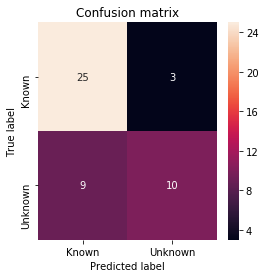

In [27]:
plot_confusion_matrix(cm_rf)

#### Logistic Regression

In [28]:
tfidf_vect = TfidfVectorizer(use_idf= True,sublinear_tf= True,norm= 'l1',preprocessor=text_process,
                             ngram_range= (1, 3),min_df= 2,max_features=3000,max_df=0.9)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [29]:
accuracy_lr, recall_lr, precision_lr, f1_lr,roc_lr,cm_lr,pred_lr=train_model(LogisticRegression(random_state=15325,penalty='l1',C=1000),xtrain_tfidf, y_train, xtest_tfidf,y_test)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=15325, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
Accuracy: 0.6382978723404256
Recall: 0.4090909090909091
Precision: 0.6923076923076923
F1: 0.5142857142857142
ROC: 0.7692307692307692
CM: [[21  4]
 [13  9]]


[[21  4]
 [13  9]]


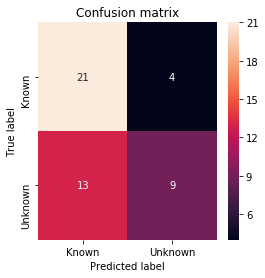

In [30]:
plot_confusion_matrix(cm_lr)

#### Naive Bayes

In [31]:
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf=True,norm= 'l2',preprocessor=text_process,ngram_range= (1,5),
                             min_df= 2,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [32]:
accuracy_nb, recall_nb, precision_nb, f1_nb,roc_nb,cm_nb,pred_nb = train_model(MultinomialNB(alpha=0.001),
                                                                       xtrain_tfidf, y_train, xtest_tfidf,y_test)


MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True) 
Accuracy: 0.425531914893617
Recall: 0.28125
Precision: 0.6923076923076923
F1: 0.4
ROC: 0.5610859728506787
CM: [[11  4]
 [23  9]]


[[11  4]
 [23  9]]


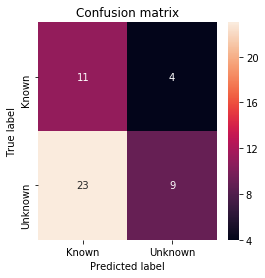

In [33]:
plot_confusion_matrix(cm_nb)

#### Gradient Boosting

In [34]:
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf= True,norm= 'l1',preprocessor=text_process,
                             ngram_range= (1, 2),min_df= 4,max_features=7000,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)


In [35]:
accuracy_gb, recall_gb, precision_gb, f1_gb,roc_gb,cm_gb,pred_gb=train_model(GradientBoostingClassifier(min_samples_leaf= 1,
                                 min_samples_split= 20,max_features= 'auto',max_depth=1, learning_rate= 0.05,n_estimators=100,random_state=15325),
            xtrain_tfidf, y_train, xtest_tfidf,y_test)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=1,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=20,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=15325, subsample=1.0, verbose=0,
              warm_start=False) 
Accuracy: 0.7872340425531915
Recall: 0.5882352941176471
Precision: 0.7692307692307693
F1: 0.6666666666666667
ROC: 0.8506787330316742
CM: [[27  3]
 [ 7 10]]


[[27  3]
 [ 7 10]]


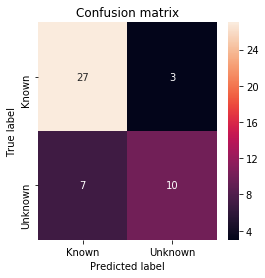

In [36]:
plot_confusion_matrix(cm_gb)

### ROC CURVE 

<Figure size 432x288 with 0 Axes>

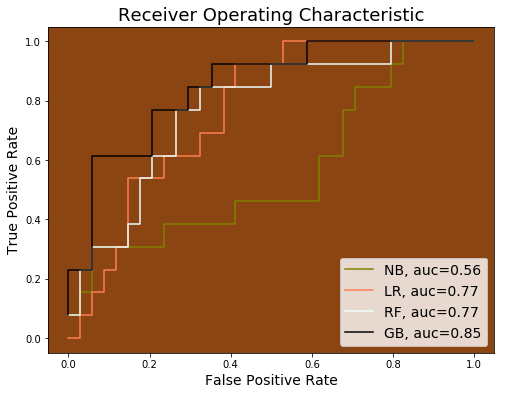

In [80]:
plt.figure(0).clf()
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Receiver Operating Characteristic',fontsize=18)
ax.set_facecolor('saddlebrown')


fpr, tpr, thresh = roc_curve(y_test, pred_nb)
auc = roc_auc_score(y_test, pred_nb)
plt.plot(fpr,tpr,'olive',label="NB, auc="+str(round(auc, 2)))


fpr, tpr, thresh = roc_curve(y_test, pred_lr)
auc = roc_auc_score(y_test, pred_lr)
plt.plot(fpr,tpr,'coral',label="LR, auc="+str(round(auc, 2)))


fpr, tpr, thresh = roc_curve(y_test, pred_rf)
auc = roc_auc_score(y_test, pred_rf)
plt.plot(fpr,tpr,'azure',label="RF, auc="+str(round(auc, 2)))





fpr, tpr, thresh = roc_curve(y_test, pred_gb)
auc = roc_auc_score(y_test, pred_gb)
plt.plot(fpr,tpr,'black',label="GB, auc="+str(round(auc, 2)))



plt.legend(loc = 'lower right',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)

plt.show()
fig.savefig('layer2roc.jpg')